# Homework 2

This assignment is due Friday, February 24 at 11:59pm Central Time. 

This assignment can be completed in **groups of two**. If you need to find a partner, please post in the pinned note on Piazza.

Once you have formed your groups, the work you submit must belong only to your group members. Do not submit another team's work as your own, and do not allow another team to submit your work as their own. If you use resources you find online, you must cite those in your notebook.

To submit this assignment, you should commit to your GitHub account:

* your Net ID(s) in the netid file; one per line. Please do not put your name in your notebook; we will grade these anonymously.

* a hw2.pdf printout of the completed notebook that shows all your answers.

* your final hw2.ipynb notebook with outputs saved. If we run your notebook from scratch, it should produce an output identical to your PDF. You can edit your notebook however you want (on Colab, on your local machine, somewhere else); just upload the latest version of it to GitHub.

Your GitHub account must submit contain all three of these, or you will lose points. We will not accept late work except in extreme settings.

In [23]:
# If using local runtime
# base_dir = "~/Documents"
# If using hosted runtime
base_dir = "/content"

# helper code from the course repository
!cd $base_dir && git clone -q https://github.com/zachwooddoughty/cs449w23.git
# install common pacakges used for deep learning
!cd $base_dir/cs449w23/ && pip install -q -r requirements.txt

# make sure we're in the right directory
%cd $base_dir/cs449w23/
!git pull -q origin main

fatal: destination path 'cs449w23' already exists and is not an empty directory.
/content/cs449w23


In [24]:
%matplotlib inline

import datetime
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from matplotlib.animation import FuncAnimation
from pathlib import Path
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
from tqdm import tqdm

from utils.gan import *

## GANs and Autoencoders

This homework assignment builds off the GAN notebook and the Autoencoder notebook that we saw in class. You may copy any code from those notebooks into your code.

For this assignment, you will combine the models introduced in those two notebooks to create a combined Autoencoder + GAN model. In particular, that will look something like this:

![Diagram of model architecture](https://github.com/zachwooddoughty/cs449w23/raw/main/static/hw2_fig.png)

We're giving you the defined models below and the skeleton of the training code, and you just need to define the optimizers and write the loss functions to allow these models to train together.

If we write this in a functional representation, then the encoder $E(X)$ takes in a real image and outputs a $z$ vector, $G(z)$ takes in a $z$ vecotr and outputs an image $\tilde X$, and $D(X)$ takes in an image and outputs a scalar probability.

The autoencoder loss will be MSELoss comparing $X$ and $\tilde X$ and the generator and discriminator will be otherwise the same as in a GAN. However, the tricky component is to get the model to train and reduce all three losses simultaneously.

In [25]:
class MLPGenerator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP generator"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Generator number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [output_size] # final output should be the size of a true example
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply Sigmoid after final layer to constrain generated images to [0, 1]
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPDiscriminator(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 activation: torch.nn.Module):
        """Construct a simple MLP discriminator"""
        
        super().__init__()
        
        msg = "Discriminator number_of_hidden_layers must be at least 0"
        assert number_of_hidden_layers >= 0, msg
        
        # final output dimension is scalar (probability image is real)
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [1]
        
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)
        
        # apply sigmoid after final layer to represent probability
        layers.append(torch.nn.Sigmoid())
        
        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)

class MLPEncoder(torch.nn.Module):
    
    def __init__(self, 
                 number_of_hidden_layers: int, 
                 input_size: int, 
                 hidden_size: int, 
                 latent_size: int,
                 activation: torch.nn.Module):
        """Construct a simple MLP encoder"""
        
        super().__init__()
        
        assert number_of_hidden_layers >= 0, "Encoder number_of_hidden_layers must be at least 0"
        
        dims_in = [input_size] + [hidden_size] * number_of_hidden_layers
        dims_out = [hidden_size] * number_of_hidden_layers + [latent_size]  # final output should be latent size
        layers = []
        for i in range(number_of_hidden_layers + 1):
            layers.append(torch.nn.Linear(dims_in[i], dims_out[i]))
            
            if i < number_of_hidden_layers:
                layers.append(activation)

        self.net = torch.nn.Sequential(*layers)
    
    def forward(self, x: torch.Tensor):
        return self.net(x)


class Model(torch.nn.Module):
    def __init__(self,
                 number_of_hidden_layers: int, 
                 latent_size: int, 
                 hidden_size: int, 
                 output_size: int,
                 activation_generator: torch.nn.Module = torch.nn.ReLU(),
                 activation_discriminator: torch.nn.Module = torch.nn.LeakyReLU(0.2)
                ):
        
        super().__init__()

        self.encoder = MLPEncoder(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=output_size, 
            hidden_size=hidden_size, 
            latent_size=latent_size,
            activation=activation_generator,
        )
                          
        self.generator = MLPGenerator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=latent_size, 
            hidden_size=hidden_size, 
            output_size=output_size,
            activation=activation_generator
        )
        
        self.discriminator = MLPDiscriminator(
            number_of_hidden_layers=number_of_hidden_layers, 
            input_size=output_size, 
            hidden_size=hidden_size,
            activation=activation_discriminator
        )   

In [26]:
# training hyperparameters
image_size = 28
batch_size = 64
latent_size = 64
hidden_size = 256
number_of_hidden_layers = 2
lr = 0.00002

# select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load MNIST dataset
mnist = load_mnist(batch_size=batch_size)

# initialize the model
model = Model(
    number_of_hidden_layers=number_of_hidden_layers, 
    latent_size=latent_size, 
    hidden_size=hidden_size, 
    output_size=image_size*image_size, 
).to(device)

# discriminator loss function: binary cross-entropy loss
discrim_loss_func = torch.nn.BCELoss()
# autoencoder loss function: mean squared error between original and new image
autoencoder_loss_func = torch.nn.MSELoss()

# determine which labels will correspond to "real" and "fake" predictions from the discriminator
label_real = 1.0
label_fake = 0.0

# select a fixed set of latent vectors z that we will use to visualize the GAN's generation quality each epoch
fixed_latents = torch.randn((batch_size, latent_size)).to(device)

## Coding (7 points)

To get this code to run, you need to do two things.

* First, instantiate the optimizer(s) you will use to update your model parameters. Remember that you will need to update parameters in `model.encoder`, `model.generator`, and `model.discriminator`. One decision you have to make is how many optimizers you want to use.

* Write the training code below to compute the loss terms for each part of your model: `loss_discriminator`, `loss_generator`, and `loss_autoencoder`. As in the VAE notebook, you may want to consider weighting these losses differently.

For full points, we must be able to run your notebook as is and reproduce (almost) exactly the same results.

In [27]:
# fix random seed
torch.manual_seed(0)

epochs = 10

# use an optimizer to handle parameter updates
opt_encoder = torch.optim.Adam(model.encoder.parameters(), lr=lr)
opt_generator = torch.optim.Adam(model.generator.parameters(), lr=lr)
opt_discriminator = torch.optim.Adam(model.discriminator.parameters(), lr=lr)
label_real = 1.0
label_fake = 0.0
# en_w = 1
# gen_w = 1
# dis_w = 1


loss = torch.nn.MSELoss()

# log metrics
loss_d = np.zeros(epochs)
loss_g = np.zeros(epochs)
loss_ae = np.zeros(epochs)

for epoch in range(epochs):
    total_epoch_size = 0
    for batch_idx, batch_data in enumerate(mnist):
        # Zero out grads at beginning of epoch
        model.encoder.zero_grad()
        model.discriminator.zero_grad()
        model.generator.zero_grad()

        x_real, y_real = batch_data
        
        # flatten input images and move to device
        x_real = x_real.to(device)
        n_batch = x_real.shape[0]
        x_real = x_real.reshape(n_batch, -1)

        # TODO: write your training code here to compute loss functions
        #   for each model section
        # train on a batch of inputs
        y_real_label = torch.full((n_batch, 1), label_real, device=device)
        y_fake_label = torch.full((n_batch, 1), label_fake, device=device)

        # autoencoder loss
        z = model.encoder(x_real)
        x_reconstructed = model.generator(z)
        loss_autoencoder = loss(x_real, x_reconstructed)
        loss_autoencoder.backward()
        opt_encoder.step()

        # generator loss
        preds_fake = model.discriminator(x_reconstructed.detach())
        loss_generator = loss(preds_fake, y_real_label)
        loss_generator.backward()
        opt_generator.step()

        # #  discriminator loss
        preds_real = model.discriminator(x_real)
        loss_real = loss(preds_real, y_real_label)

        preds_fake = model.discriminator(x_reconstructed.detach())
        loss_fake = loss(preds_fake, y_fake_label)

        loss_discriminator = (loss_real + loss_fake)
        loss_discriminator.backward()
        opt_discriminator.step()
        
        # loss_discriminator = torch.tensor(0)
        # loss_generator = torch.tensor(0)
        # loss_autoencoder = torch.tensor(0)
        
        # log losses and scores
        loss_d[epoch] += loss_discriminator.detach().item() * n_batch
        loss_g[epoch] += loss_generator.detach().item() * n_batch
        loss_ae[epoch] += loss_autoencoder.detach().item() * n_batch
        total_epoch_size += n_batch

    loss_d[epoch] /= total_epoch_size
    loss_g[epoch] /= total_epoch_size
    loss_ae[epoch] /= total_epoch_size

    if epoch == 0 or (epoch + 1) % max(1, epochs // 10) == 0:
        total = loss_ae[epoch] + loss_g[epoch] + loss_d[epoch]
        log = "  ".join([
            f"Epoch: {epoch + 1:4d}",
            f"AE Loss: {loss_ae[epoch]:8.1f}",
            f"Gen Loss: {loss_g[epoch]:8.1f}",
            f"Dis Loss: {loss_d[epoch]:8.1f}",
            f"Total: {total:8.1f}",
        ])
        print(log)

Epoch:    1  AE Loss:      0.1  Gen Loss:      0.2  Dis Loss:      0.4  Total:      0.7
Epoch:    2  AE Loss:      0.1  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.6
Epoch:    3  AE Loss:      0.1  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.6
Epoch:    4  AE Loss:      0.1  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.6
Epoch:    5  AE Loss:      0.1  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.6
Epoch:    6  AE Loss:      0.0  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.6
Epoch:    7  AE Loss:      0.0  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.6
Epoch:    8  AE Loss:      0.0  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.6
Epoch:    9  AE Loss:      0.0  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.5
Epoch:   10  AE Loss:      0.0  Gen Loss:      0.2  Dis Loss:      0.3  Total:      0.5


Once you've trained your model, use the next two cells to sample some images from your generator.

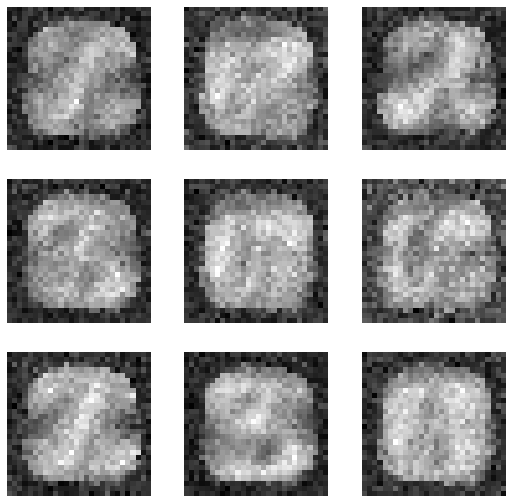

In [30]:
nrows, ncols = (3, 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(3 * nrows, 3 * ncols))

for row in range(nrows):
    for col in range(ncols):
        z = torch.randn(1, latent_size).to(device)
        output = model.generator(z).reshape(image_size, image_size).detach().cpu()
        axes[row, col].imshow(output.squeeze(), cmap='gray')
        axes[row, col].axis('off')

plt.show()

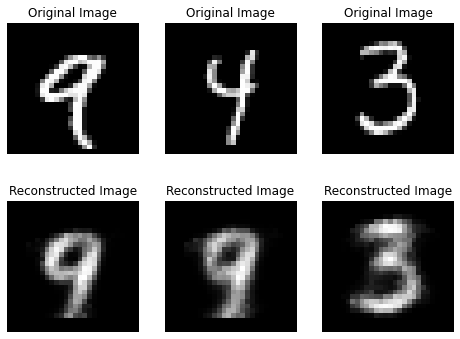

In [31]:
example_batch = next(iter(mnist))[0].to(device)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

indices = np.argsort(np.random.rand(example_batch.shape[0]))[:3]

for col, index in enumerate(indices):

    example_image = example_batch[index].cpu()
    axes[0, col].imshow(example_image.squeeze(), cmap='gray')
    axes[0, col].set_title("Original Image")
    axes[0, col].axis('off')

    image_input = example_image.flatten().unsqueeze(0).to(device)
    recons_img = model.generator(model.encoder(image_input))
    recons_img = recons_img.reshape(1, image_size, image_size).detach().cpu()
    axes[1, col].imshow(recons_img.squeeze(), cmap='gray')
    axes[1, col].set_title("Reconstructed Image")
    axes[1, col].axis('off')

plt.show()

## Coding explanation (6 points)

### 1. What did you do? (4 points)

Describe your approach in your code above; what choices did you make and why?

We used three optimizers: one for the autoencoder, generators and discriminator. This was because this enabled us to accurately think about which loss we were actually calculating and what we were trying to optimize. For the autoencoder, we calculate the loss as the difference between the generators ouputs and the real images. For the generator, we calculate the loss as the reconstructed images that the discriminator was able to predict as fake. We detached the gradients from the encoder to ensure only the generator was trained. For the discriminator we did the same but we also calculated the loss as the real images that the discriminator was not able to tell as real. For the reconstructed images, we detached them from the generator inorder to only train the discriminator.


If you weren't able to get the model to train, you can still earn these points by describing what you tried and what didn't seem to work.

### 2. Discuss your results (2 points)

If you were able to get your model to train, what did you notice about the trends in the three different loss values? How do your generated images in the previous cells look similar to or different from the images we saw in the GAN or Autoencoder notebooks?

The AE loss was always the lowest followed by the generator and then the discriminator. We hypothesize that the discriminator had the highest loss because because the AE and generator were working to make the best reconstructed images.

The reconstructured images from the GAN notebook look more high quality than the ones we generated. Ours seems to have more noise even though we can see the general features of the digits forming.

The same applies to the autoencoder notebook.

The reason is that the different loss functions were working in different directions.

## Conceptual questions (7 points)

### 1. Mode collapse (2 points)

Look back at the slides, notebook, and/or readings around mode collapse in GANs.
* First, give a one or two sentence definition of what mode collapse is, in your own words.

Mode collapse is a phenomenon where a GAN produces limited variations of output samples, failing to capture the full diversity of the training data. Basically, there is a combination of features that seem to fool the discriminator and the model gets “too comfortable” in learning those features that it just settles to the mode of the distribution and ends up spitting out non-varied outputs.

* Second, explain why mode collapse is *more* or *less* likely in the above model that incorporates an autoencoder into the GAN. Write at least two sentences.

I think incorporating an autoencoder into a GAN may make mode collapse more likely to occur. This is because the autoencoder compresses the input data into a lower-dimensional representation, which can lessen the input data variety. This way we could have multiple points in a higher dimensional space getting mapped to fewer points in a lower dimensional space which may not capture all the important features of the training data.

### 2. Loss functions (3 points)

In the above model that you trained, there are different loss functions for the autoencoder, generator, and discriminator. For each pair of losses, describe whether and how the two losses are in conflict. That is, when training your model, does reducing loss #1 tend to increase loss #2? Why or why not?

* a. Generator loss and discriminator loss

The two losses are in conflict. Because the discriminator tries to maximize the loss while the generator tries to minimize the loss, If the discriminator loss is high and the generator loss is low, then the generator is doing a successful job at fooling the discriminator. So reducing the generator loss tends to increase the discriminator loss.

* b. Generator loss and autoencoder loss

The two losses go together. Because the autoencoder is being fed into the discriminator, if it has a high loss (doing a poor job at compressing the data), this would affect the decompressed data that the generator spits out which may end up doing a poor job at fooling the discriminator, and in that way, increase the generator loss. So reducing the generator loss tends to reduce the autoencoder loss.

* c. Discriminator loss and autoencoder loss

Since the autoencoder works alongside the generator, if it has a high loss, it’ll affect how bad the generator loss would be, which would, in turn, make it worse at fooling the discriminator and in that case make the discriminator loss go low. So reducing the discriminator loss tends to increase the autoencoder loss.


### 3. Class conditioning (2 points)

Suppose you wanted to add in class-conditioning to [the generator and discriminator](https://arxiv.org/pdf/1411.1784.pdf) and [the autoencoder](https://proceedings.neurips.cc/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf) in your model. How and why would this change your loss function(s)?

Incorporating class conditioning would involve adding additional terms that encourage the generator and the autoencoder to generate output data that belongs to the specified class. This way, the loss functions could be “hardcoded” to perform better, and thus make them lower.